<a href="https://colab.research.google.com/github/JuanPedroDelCastillo/FisicaComputacional1/blob/master/Evaluaci%C3%B3n1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluación 1
**Juan Pedro Del Castillo valencia**

**Observatorio Tutuila, Samoa Americana**



*Importar Bibliotecas*

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

## Parte 1. Construcción de una Serie de Tiempo. 

In [71]:
# Los archivos de datos contienen las observaciones promedio diarias. 
# Al principio de cada archivo indica cuantas líneas contiene el encabezado, 
# para considerarlo a la hora de leer el archivo CSV (aquí separado por espacios).

url = "https://raw.githubusercontent.com/JuanPedroDelCastillo/FisicaComputacional1/master/Evaluacion1/co2_AmericanSamoa.txt"

my_cols = ['site_code', 'year', 'month', 'day', 'hour', 'minute', 'second', 'time_decimal', 'value', 'value_std_dev', 'nvalue', 
           'latitude', 'longitude', 'altitude', 'elevation', 'intake_height', 'qcflag']

df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=151, engine='python')


# Nos interesa la columna de 'value' que corresponde a las concentraciones de CO2. 
# Cuando hay datos faltantes, aparece el número -999.99. Habrá que reemplazarlo por NaN. 
# Las series de tiempo son de mediados de 1970 al 2019-12-31. 

df_work = df_dist.copy()

df_work = df_work.drop(columns=['site_code', 'hour', 'minute', 'second', 
                                'time_decimal', 'value_std_dev', 'nvalue', 
                                'latitude', 'longitude', 'altitude', 
                                'elevation', 'intake_height', 'qcflag'])

df_work = df_work.replace(to_replace=-999.99, value=np.NaN, regex=True)

# Para construir una serie de tiempo que deseamos analizar, se pide construir 
# una columna de 'Fecha' variable de tipo datetime,  combinando las columnas 
# 'year', 'month', y 'day'.  

df_work['Fecha'] = df_work['day'].astype(str)+'/'+df_work['month'].astype(str)+'/'+df_work['year'].astype(str)
df_work['Fecha'] = pd.to_datetime(df_work['Fecha'], dayfirst=True)
df_work = df_work.drop(columns=['day', 'month', 'year'])




# Después se pide construir un dataframe que contiene desde el inicio de 
# 1980 hasta fin de 2019.
# Convierte el dataframe anterior a serie de tiempo 'ts_test', usando 'Fecha' como índice. 
# La serie de tiempo de concentraciones de CO2, sólo deberá tener la Fecha como 
# índice y la columna de CO2. 

df_work = df_work.set_index('Fecha')
ts_test0 = df_work.loc['1980-01-01':'2019-12-31']

# Puedes usar la función de Pandas ts_test.ffill(axis = 0, inplace=True), 
# para rellenar hacia enfrente los valores vacíos en base al último valor anterior disponible.  

ts_test0.ffill(axis = 0, inplace=True)
ts_test = ts_test0['value'].copy()

print(ts_test.head())
print(ts_test.tail())

Fecha
1980-01-01    337.25
1980-01-02    337.25
1980-01-03    337.56
1980-01-04    337.69
1980-01-05    337.83
Name: value, dtype: float64
Fecha
2019-12-27    410.89
2019-12-28    410.89
2019-12-29    410.89
2019-12-30    410.89
2019-12-31    410.89
Name: value, dtype: float64


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


## Parte 2. Análisis de la Serie de Tiempo.

In [72]:
# Define una función para probar estacionaridad utilizando la Prueba Avanzada de 
# Dickey-Fuller: test_stationarity(df_ts)

# Definimos una función como test de la estacionaridad de una serie de tiempo

def test_stationarity(df_ts):

  # Estadística de Promedios Móviles
  rolmean = df_ts.rolling(window=365, center=True).mean()
  rolstd = df_ts.rolling(window=365, center=True).std()

  # Gráfica de la estadística
  plt.rcParams['figure.figsize'] = (12, 6)
  plt.plot(df_ts, color='blue', label='Original')
  plt.plot(rolmean, color='red', label='Rolling Mean')
  plt.plot(rolstd, color='black', label='Rolling Std Deviation')
  plt.legend(loc='best')
  plt.title('Promedio Móvil y Desviación Estaádar')
  plt.grid()
  plt.show()

  #Prueba aumentada de Dickey-Fuller
  #Si el valor es menor al 5% entonces la serie es estacionaria
  print('Resultados de la Prueba de Dickey-Fuller:')
  dftest = adfuller(df_ts, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], 
                       index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
  print(dfoutput)

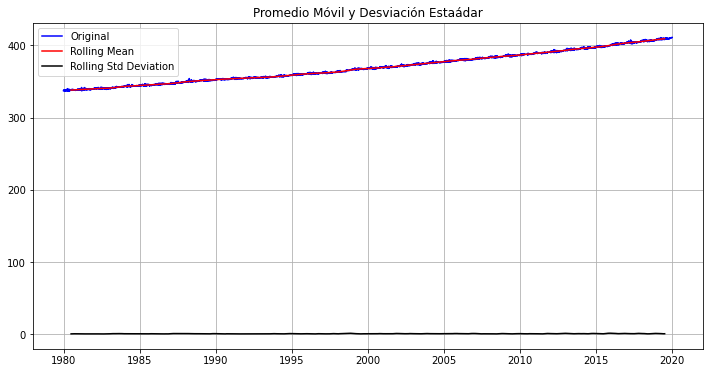

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                     1.351348
p-value                            0.996882
#Lags Used                        39.000000
Number of Observations Used    14570.000000
Critical Value (1%)               -3.430799
Critical Value (5%)               -2.861738
Critical Value (10%)              -2.566876
dtype: float64


In [73]:
# Prueba la estacionaridad de tu serie de tiempo 'ts_test' en base al valor p.
test_stationarity(ts_test)

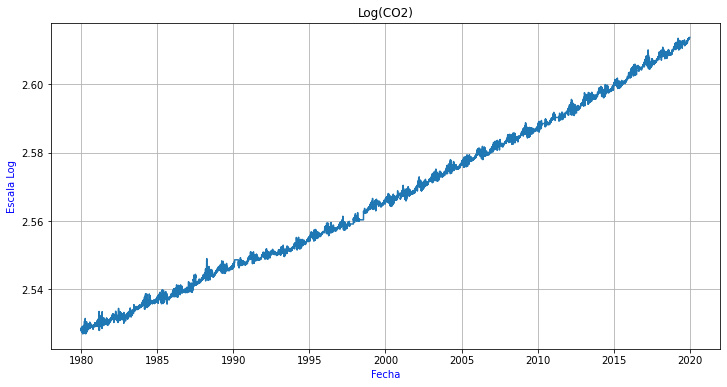

In [75]:
# Si no es una serie de tiempo estacionaria, cambia de escala a Log(CO2), y gráfica la nueva función.
ts_test_log = np.log10(ts_test)

plt.plot(ts_test_log)
plt.xlabel('Fecha',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Log(CO2)')
plt.grid()
plt.show();


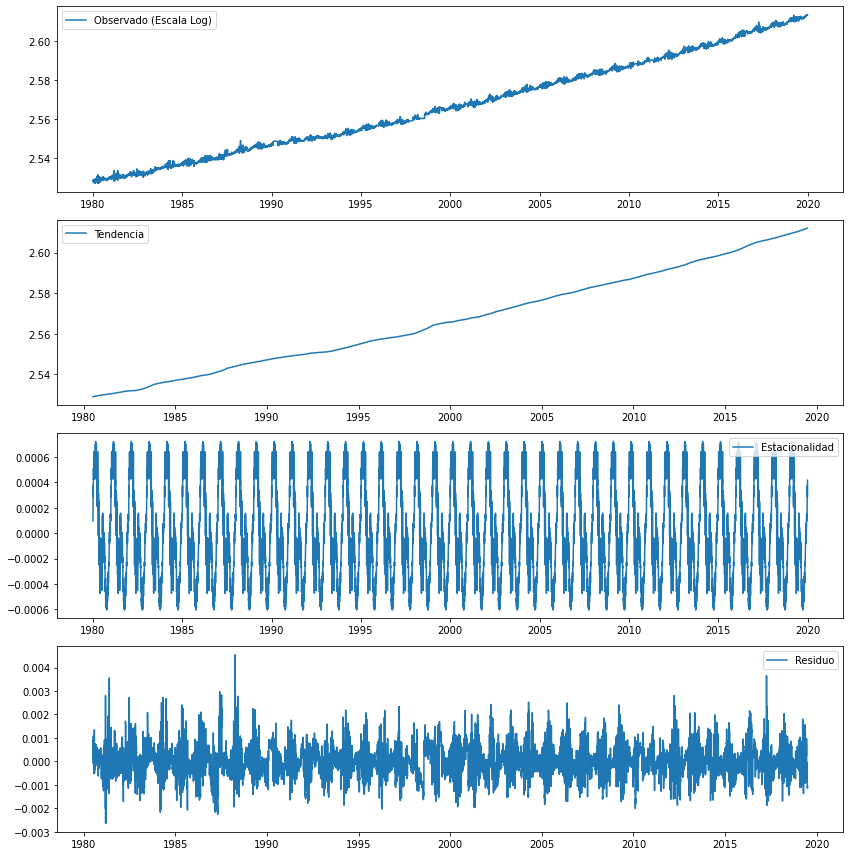

In [76]:
# Haz una descomposición estacional de la serie 'ts_test_log', usando interpolación, 
# y promedio móvil de 365 días. Produce las gráficas de las series que la componen. 
# Comenta la serie de tendencia (aumento de CO2), estacionalidad (dependencia de las 
# estaciones del año) y residuo (el resto).  

# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

La tendencia muestra un comportamiento parecida a una línea recta creciente. Como esta tendencia corresponde al logaritmo de CO2, esto significa que el CO2 tiene un aumento exponencial con respecto al tiempo.

La estacionalidad muestra que los máximos durante el año se encuentra a principios de año, mientras que los mínimos se encuentran a mitad de año.

El residuo parece variar poco, para comprobarlo realizamos la prueba.

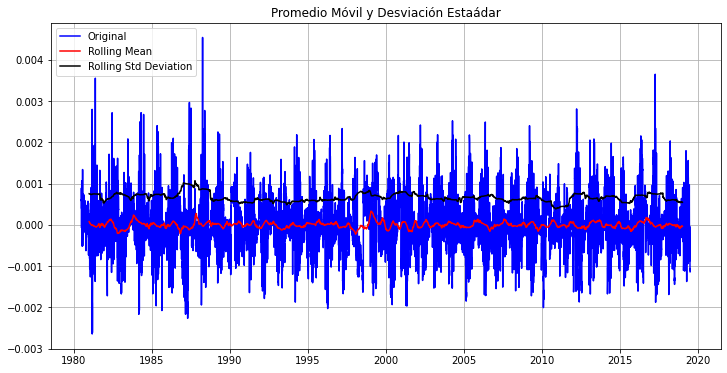

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.815980e+01
p-value                        2.463081e-30
#Lags Used                     2.100000e+01
Number of Observations Used    1.422400e+04
Critical Value (1%)           -3.430810e+00
Critical Value (5%)           -2.861743e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [77]:
# Prueba la estacionaridad de la serie residuo. 

ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
test_stationarity(ts_test_log_decompose)


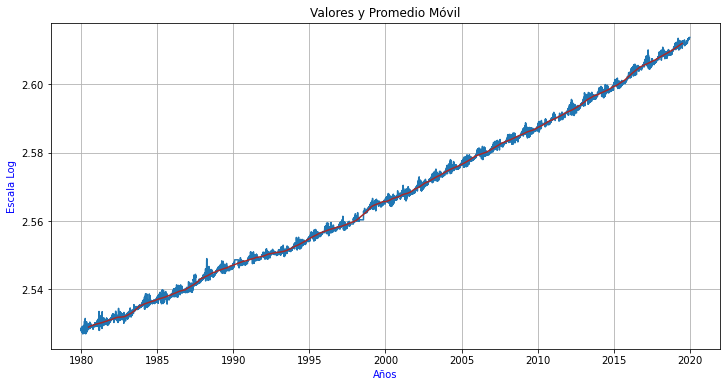

In [78]:
# Luego calcula un promedio móvil centrado sobre 'ts_test_log' usando un periodo 
# de 365 días y contrastarlo en una gráfica con la serie de Log CO2.

moving_avg = ts_test_log.rolling(365, center=True).mean()

plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown')
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

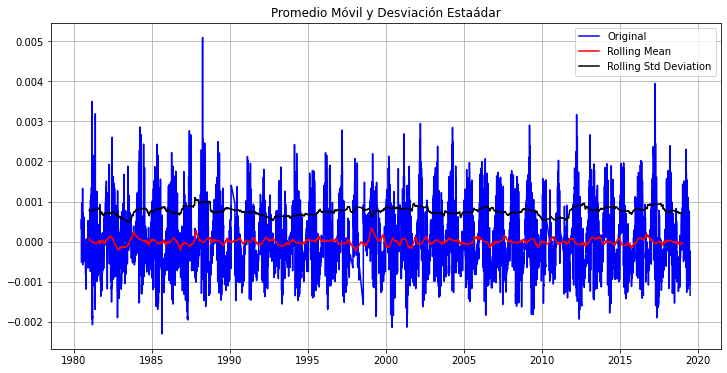

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.280448e+01
p-value                        6.645984e-24
#Lags Used                     2.800000e+01
Number of Observations Used    1.421700e+04
Critical Value (1%)           -3.430810e+00
Critical Value (5%)           -2.861743e+00
Critical Value (10%)          -2.566878e+00
dtype: float64


In [79]:
# Define un nuevo dataframe con la diferencia entre la serie logaritmo original 
# y el promedio móvil, y prueba después su estacionaridad.

ts_test_log_moving_ave_diff = ts_test_log - moving_avg 
ts_test_log_moving_ave_diff.dropna(inplace=True)
test_stationarity(ts_test_log_moving_ave_diff)

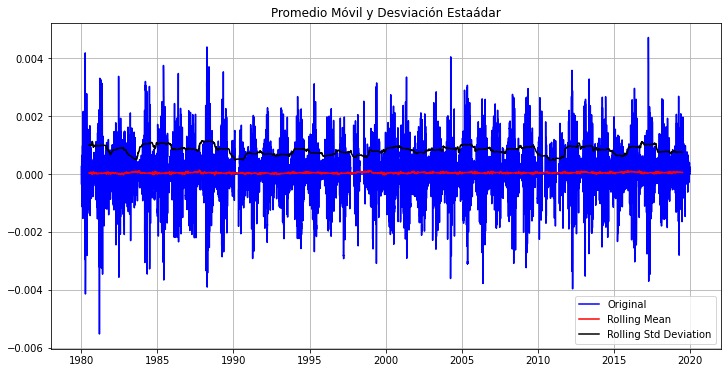

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -22.689055
p-value                            0.000000
#Lags Used                        42.000000
Number of Observations Used    14560.000000
Critical Value (1%)               -3.430799
Critical Value (5%)               -2.861739
Critical Value (10%)              -2.566876
dtype: float64


In [81]:
# Adicionalmente, prueba construir una serie estacionaria usando la función de 
# diferenciación shift con un periodo de 7 días, que utiliza menos puntos que 
# el promedio móvil.   
# Prueba la estacionaridad de esa última serie de tiempo 'ts_test_log_diff'

ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
ts_test_log_diff.dropna(inplace=True)
test_stationarity(ts_test_log_diff)

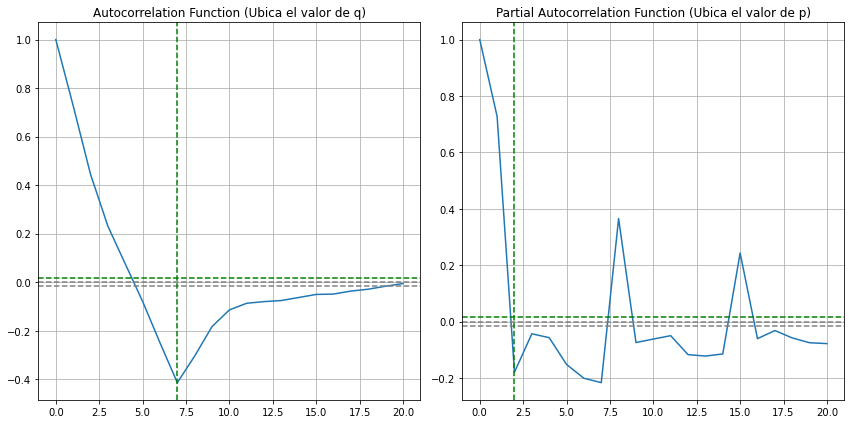

In [83]:
# Construye un modelo ARIMA de la serie 'ts_test_log_diff', calculando los 
# parámetros p, q y utiliza d=1

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')

# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')

plt.axvline(x=7, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')

# Graficamos unas líneas verticales como referencias 

plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14609
Model:                 ARIMA(2, 1, 7)   Log Likelihood               93157.431
Method:                       css-mle   S.D. of innovations              0.000
Date:                Wed, 24 Feb 2021   AIC                        -186292.862
Time:                        23:54:40   BIC                        -186209.379
Sample:                    01-02-1980   HQIC                       -186265.128
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.846e-06    7.8e-07      7.491      0.000    4.32e-06    7.38e-06
ar.L1.D.value     0.1812        nan        nan        nan         nan         nan
ar.L2.D.value     0.1784        nan     

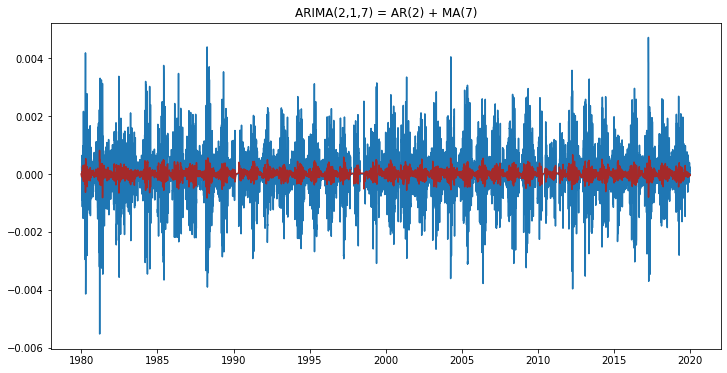

In [84]:
# Modelo ARIMA(p): (p,d,q) = (2,1,7) 
model = ARIMA(ts_test_log, order=(2,1,7), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,7) = AR(2) + MA(7)')
print(results_ARIMA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14609
Model:                 ARIMA(2, 1, 0)   Log Likelihood               92545.287
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -185082.574
Time:                        00:03:51   BIC                        -185052.217
Sample:                    01-02-1980   HQIC                       -185072.489
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.867e-06   3.09e-06      1.897      0.058   -1.94e-07    1.19e-05
ar.L1.D.value    -0.0003      0.008     -0.033      0.974      -0.016       0.016
ar.L2.D.value    -0.1478      0.008    -

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14609
Model:                 ARIMA(0, 1, 7)   Log Likelihood               93077.652
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -186137.304
Time:                        00:04:02   BIC                        -186068.999
Sample:                    01-02-1980   HQIC                       -186114.612
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.842e-06   4.75e-07     12.310      0.000    4.91e-06    6.77e-06
ma.L1.D.value    -0.0612      0.009     -7.043      0.000      -0.078      -0.044
ma.L2.D.value    -0.1953      0.008    -

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                14609
Model:                 ARIMA(2, 1, 7)   Log Likelihood               93157.431
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -186292.862
Time:                        00:05:01   BIC                        -186209.379
Sample:                    01-02-1980   HQIC                       -186265.128
                         - 12-31-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          5.846e-06    7.8e-07      7.491      0.000    4.32e-06    7.38e-06
ar.L1.D.value     0.1812        nan        nan        nan         nan         nan
ar.L2.D.value     0.1784        nan     

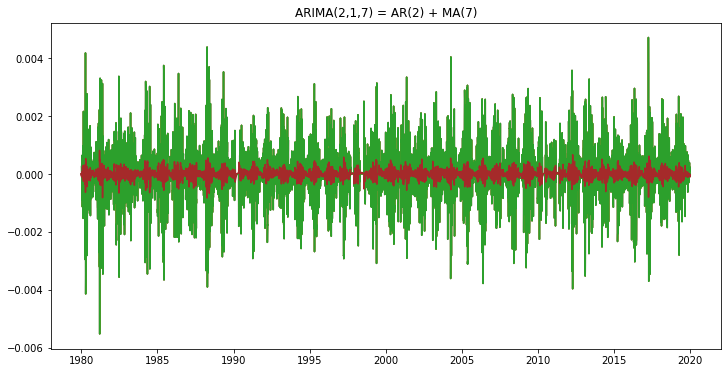

In [85]:
# Para seleccionar el mejor modelo, calcula el Criterio de Información de 
# Akaike (AIC) de los modelos: AR(p), MA(q), y ARIMA (p,d,q). 

# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

# Modelo MA(q): (p,d,q) = (0,1,7) 
model = ARIMA(ts_test_log, order=(0,1,7), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,7) = MA(7)')
print(results_MA.summary())

# Modelo ARIMA(p,q): (p,d,q) = (2,1,7) 
model = ARIMA(ts_test_log, order=(2,1,7), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,7) = AR(2) + MA(7)')
print(results_ARIMA.summary())

El mejor modelo resultó siendo el ARIMA(2, 1, 7)

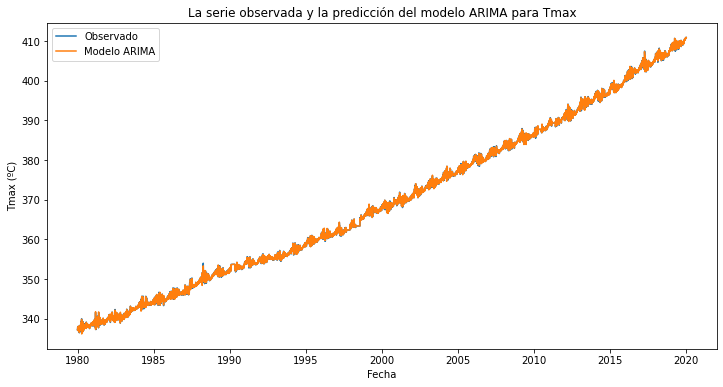

In [89]:
# Contrasta la serie observada de concentraciones de CO2 contra la construida por el modelo ARIMA.
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_log = pd.Series(ts_test_log, index = ts_test_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
predictions_ARIMA = 10**(predictions_ARIMA_log)

plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [90]:
# Calcula el error RMSE

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 0.11448964942151307


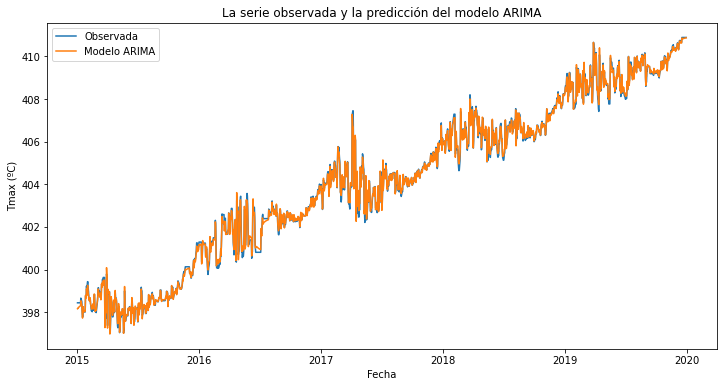

In [92]:
# Por último contrasta los 5 últimos años de la Serie de CO2 y el modelo ARIMA 
# para ver mas a detalles el modelo.

ts_test_last = ts_test.tail(1825)
predictions_ARIMA_last = predictions_ARIMA.tail(1825)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');